# Demos: Lecture 18

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

from lecture18_helpers import *

## Demo 1: mitigating error in noisy VQE simulations

Ground state of $H_2$ looks like:

$$
|\psi_g(\theta)\rangle = \cos(\theta/2) |1100\rangle - \sin(\theta/2) |0011\rangle
$$

In [2]:
bond_length = 1.3228
symbols = ["H", "H"]
coordinates = np.array([0.0, 0.0, -bond_length/2, 0.0, 0.0, bond_length/2])

H, n_qubits = qml.qchem.molecular_hamiltonian(symbols, coordinates)

/home/olivia/Software/anaconda3/envs/cpen400q/lib/python3.9/site-packages/pyscf/lib/misc.py:46: H5pyDeprecationWarning: Using default_file_mode other than 'r' is deprecated. Pass the mode to h5py.File() instead.
  h5py.get_config().default_file_mode = 'a'


In [3]:
dev = qml.device("default.qubit", wires=4)

def prepare_ground_state(theta):
    qml.PauliX(wires=0)
    qml.PauliX(wires=1)
    qml.DoubleExcitation(theta, wires=range(4))
    return qml.expval(H)

optimal_theta = np.array(0.20973288, requires_grad=True)

In [4]:
ideal_qnode = qml.QNode(prepare_ground_state, dev)

In [5]:
ideal_qnode(optimal_theta)

tensor(-1.13618916, requires_grad=True)

In [6]:
from qiskit.test.mock import FakeSantiago
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise import NoiseModel

In [7]:
device = QasmSimulator.from_backend(FakeSantiago())

noise_model = NoiseModel.from_backend(device, readout_error=False)

noisy_dev = qml.device(
    "qiskit.aer", backend='qasm_simulator', wires=4, shots=10000, noise_model=noise_model
)

In [8]:
noisy_qnode = qml.QNode(prepare_ground_state, noisy_dev)

In [9]:
noisy_qnode(optimal_theta)

-1.0877490314801563

Explore what happens with a single term in the Hamiltonian.

In [11]:
def prepare_ground_state(theta, obs):
    qml.PauliX(wires=0)
    qml.PauliX(wires=1)
    qml.DoubleExcitation(theta, wires=range(4))
    return qml.expval(obs)

ideal_qnode = qml.QNode(prepare_ground_state, dev)
noisy_qnode = qml.QNode(prepare_ground_state, noisy_dev)

obs = qml.PauliY(0) @ qml.PauliY(1) @ qml.PauliX(2) @ qml.PauliX(3)

In [12]:
ideal_qnode(optimal_theta, obs)

tensor(0.20819864, requires_grad=True)

In [15]:
noisy_qnode(optimal_theta, obs)

tensor(0.1948, requires_grad=True)

In [16]:
@qml.qfunc_transform
def unitary_folding(tape, scale_factor):
    num_folds = int((scale_factor - 1)/2)
    
    for op in tape.operations:
        qml.apply(op)
        
    for _ in range(num_folds):
        for op in tape.operations:
            qml.apply(op)
            
        for op in tape.operations[::-1]:
            op.adjoint()
            
    for m in tape.measurements:
        qml.apply(m)

In [20]:
folded_qnode = qml.QNode(unitary_folding(7)(prepare_ground_state), noisy_dev)

In [22]:
folded_qnode(optimal_theta, obs)

tensor(0.1664, requires_grad=True)

In [23]:
print(qml.draw(folded_qnode)(optimal_theta, obs))

 0: ──X──╭DoubleExcitation(0.21)──X──╭DoubleExcitation(0.21)──╭DoubleExcitation(-0.21)──X──X──╭DoubleExcitation(0.21)──╭DoubleExcitation(-0.21)──X──X──╭DoubleExcitation(0.21)──╭DoubleExcitation(-0.21)──X──╭┤ ⟨Y ⊗ Y ⊗ X ⊗ X⟩ 
 1: ──X──├DoubleExcitation(0.21)──X──├DoubleExcitation(0.21)──├DoubleExcitation(-0.21)──X──X──├DoubleExcitation(0.21)──├DoubleExcitation(-0.21)──X──X──├DoubleExcitation(0.21)──├DoubleExcitation(-0.21)──X──├┤ ⟨Y ⊗ Y ⊗ X ⊗ X⟩ 
 2: ─────├DoubleExcitation(0.21)─────├DoubleExcitation(0.21)──├DoubleExcitation(-0.21)────────├DoubleExcitation(0.21)──├DoubleExcitation(-0.21)────────├DoubleExcitation(0.21)──├DoubleExcitation(-0.21)─────├┤ ⟨Y ⊗ Y ⊗ X ⊗ X⟩ 
 3: ─────╰DoubleExcitation(0.21)─────╰DoubleExcitation(0.21)──╰DoubleExcitation(-0.21)────────╰DoubleExcitation(0.21)──╰DoubleExcitation(-0.21)────────╰DoubleExcitation(0.21)──╰DoubleExcitation(-0.21)─────╰┤ ⟨Y ⊗ Y ⊗ X ⊗ X⟩ 



In [24]:
scale_factors = [1, 3, 5, 7, 9]

folded_values = []

for sf in scale_factors:
    folded_qnode = qml.QNode(unitary_folding(sf)(prepare_ground_state), noisy_dev)
    folded_values.append(folded_qnode(optimal_theta, obs))

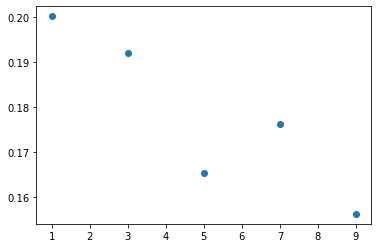

In [25]:
plt.scatter(scale_factors, folded_values)

In [26]:
from numpy.polynomial.polynomial import Polynomial

fit_func = Polynomial.fit(scale_factors, folded_values, 1)

In [27]:
fit_func(0)

0.20394999999999996

In [28]:
ideal_qnode(optimal_theta, obs)

tensor(0.20819864, requires_grad=True)

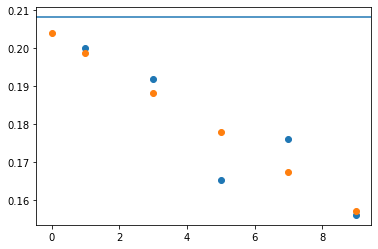

In [30]:
plt.scatter(scale_factors, folded_values)
plt.scatter([0] + scale_factors, [fit_func(x) for x in [0] + scale_factors])
plt.axhline(ideal_qnode(optimal_theta, obs))

## Demo 2: simple quantum state tomography

In [31]:
mixed_dev = qml.device("default.mixed", wires=4)

@qml.qnode(mixed_dev)
def prepare_h_state(theta):
    qml.PauliX(wires=0)
    qml.PauliX(wires=1)
    qml.DoubleExcitation(theta, wires=range(4))
    return qml.state()

In [32]:
ideal_state = prepare_h_state(optimal_theta)

/home/olivia/Software/anaconda3/envs/cpen400q/lib/python3.9/site-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: invalid value encountered in true_divide
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)


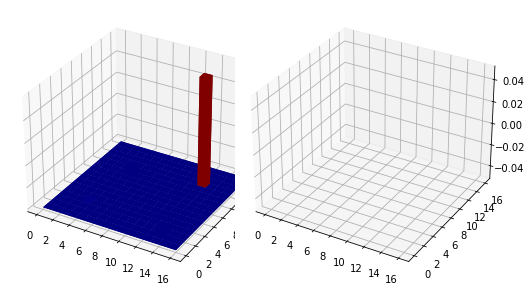

In [34]:
plot_density_matrix_city(ideal_state)

In [35]:
d = 2 ** 4

reconstructed_state = np.zeros((d, d), dtype=np.complex128)

# For each pauli
for pauli in qml.grouping.pauli_group(4):
    # Compute expectation value
    pauli_expval = noisy_qnode(optimal_theta, pauli)
    # Compute coefficient
    c = pauli_expval / d
    # Add to reconstructed matrix
    reconstructed_state += c * qml.grouping.pauli_word_to_matrix(pauli, wire_map={0:0, 1:1, 2:2, 3:3})

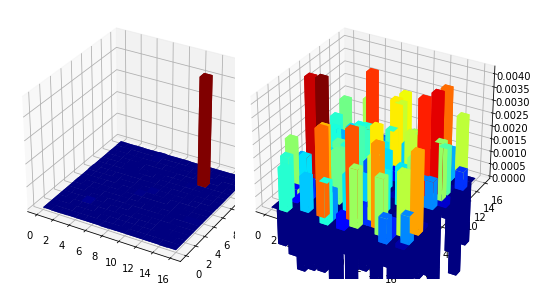

In [36]:
plot_density_matrix_city(reconstructed_state)

In [37]:
fidelity(ideal_state, reconstructed_state)

0.9616405481768466

In [38]:
trace_distance(ideal_state, reconstructed_state)

0.08555120410951572

## Demo 3: Tomography x ZNE

In [39]:
d = 2 ** 4

reconstructed_state = np.zeros((d, d), dtype=np.complex128)

# For each pauli
for pauli in qml.grouping.pauli_group(4):
    
    # Compute expectation value using ZNE
    scale_factors = [1, 3, 5]

    folded_values = []

    for sf in scale_factors:
        folded_qnode = qml.QNode(unitary_folding(sf)(prepare_ground_state), noisy_dev)
        folded_values.append(folded_qnode(optimal_theta, pauli))
    
    fit_func = Polynomial.fit(scale_factors, folded_values, 1)
    
    pauli_expval = fit_func(0)
    
    # Compute coefficient
    c = pauli_expval / d
    # Add to reconstructed matrix
    reconstructed_state += c * qml.grouping.pauli_word_to_matrix(pauli, wire_map={0:0, 1:1, 2:2, 3:3})

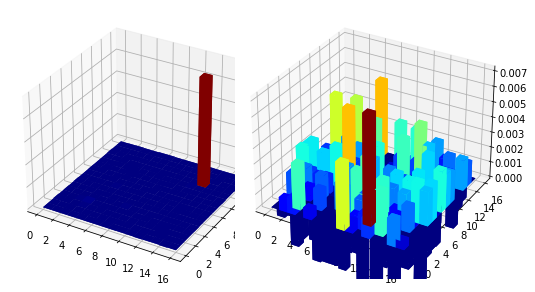

In [40]:
plot_density_matrix_city(reconstructed_state)

In [41]:
fidelity(ideal_state, reconstructed_state)

0.9802208517200868

In [42]:
trace_distance(ideal_state, reconstructed_state)

0.08147155074854545